In [1]:
%load_ext watermark
%watermark -v -n -m -p numpy,scipy,torch,geomloss,seaborn,openTSNE

Python implementation: CPython
Python version       : 3.7.4
IPython version      : 7.8.0

numpy   : 1.19.0
scipy   : 1.2.1
torch   : 1.8.1
geomloss: 0.2.3
seaborn : 0.11.1
openTSNE: 0.5.2

Compiler    : Clang 10.0.1 (clang-1001.0.46.4)
OS          : Darwin
Release     : 20.5.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit



In [2]:
import os
import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", message="distplot")
import importlib
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import torch
from IPython.display import HTML
from pathlib import Path

### Set Save Path

In [3]:
outdir = '../out/pdes_1D/'
Path(outdir).mkdir(parents=True, exist_ok=True)

### Local Imports

In [4]:
sys.path.append('../')
sys.path.append('../cpflow')
from src.flow import GradFlow
from src.utils import density_plot_1d, animate_1d_pde, meshgrid_from
from src.callbacks import CallbackList, PlottingCallback, FunctionalValueCallback, ConvergenceCallback
from src.icnn import FICNN

No rdkit
tsnecuda not found - will use (slower) cpu implementation


# 1. Porous Medium Equation

### Instantiate Initial / Exact Solution

In [5]:
from src.pde import BarenblattProfile

C  = (3/16)**(1/3)
t0 = 1e-3
m  = 2.0
ρ0 = BarenblattProfile(m, t0, C)

### Dynamics of Exact Solution

In [6]:

anim = animate_1d_pde(ρ0, 50, -1,1, interval=30)

save_path = os.path.join(outdir, 'Barenblatt_PME')
save_path = None
if save_path:
    anim.save(save_path +'.mp4')
HTML(anim.to_html5_video())

### JKO-ICNN Flow

In [7]:
from src.functionals import InternalEnergyFunctional, EntropyFunctional

### Sample Initial Particles
ρ0.reset()
X = ρ0.sample((200,))

### Define functional - nonlinear diffusion via Internal Energy Functional
f = lambda x: torch.pow(x, m)
multfun = lambda logr: torch.exp((m-1)*logr)
F = InternalEnergyFunctional(f, ρ0, X, multfun)


cb1 = PlottingCallback(animate=True, display_freq=1, same_fig=True,
                       ρ0=ρ0, 
                       show_density=True,
                       density_method='kde',  use_sns=True, density_bw=0.5,
                       figsize=(5,5), xrng=(-1,1), yrng=(0,6), 
                       show_trajectories=False, plot_pad=0.5, save_path=None)

cb = CallbackList([cb1]) 


factory = lambda: FICNN(input_dim=1, hidden_dims=[100,20], nonlin='leaky_relu', dropout=0)

gf = GradFlow(X, F=F, ρ0=ρ0,
              τ=1e-2, lr=1e-3,
              convex_net = factory,
              strongify_icnn=None,              
              optimizer='adam',
              opt_iters=400,
              callbacks=cb)

XT = gf.flow(steps=10)
plt.show()

Density BW: 0.5


------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=ℱ(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------
Relative ratio between F and W terms in JKO is too unbalanced...
consider choosing τ in 10^[-7.0,-6.0] to balance them.
   0   1.41e-02   11819.87     0.01     0.00   9.88e-02
 100   2.61e-02      -1.65     0.01     0.01   9.78e-04
 200   1.80e-02      -1.60     0.01     0.01   2.12e-04
 300   1.35e-02      -1.56     0.01     0.01   1.11e-04
 400   1.09e-02      -1.52     0.01     0.01   1.02e-04
Updating cache with: 1.66e+00  0.00e+00  6.02e-01  2.87e+00  

---> After JKO Step: 1, F(ρ)=-1.5189e+00 <---

Density BW: 0.5
------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=ℱ(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------
   0   4.77e-02      -0.82     0.01     0.01   1.75e-01
 100   7.34e-03      -0.57     0.01     0.02   9.00e-04
 200   6.34e-03      -0.54     0.0

In [8]:
HTML(cb1.animation.to_html5_video())

# 2. Nonlinear Fokker-Planck equation

### Instantiate Initial and Steady-State Distributions

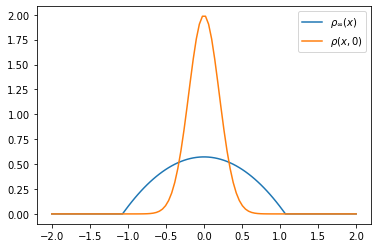

(-1.069912193933663, 1.069912193933663)

In [9]:
from src.pde import FokkerPlanckNonLinDiff

C  = (3/16)**(1/3)
t0 = 1e-3
m  = 2

x = torch.linspace(-2, 2, 100)

ρinf = FokkerPlanckNonLinDiff(m=m, C=C)

μ, σ = torch.tensor(0.0), torch.tensor(0.2)
ρ0   = torch.distributions.Normal(μ, σ)
X    = ρ0.sample((100,))
ρ0.domain = (-5.0,5.0)

fig, ax = plt.subplots()

ax.plot(x, torch.exp(ρinf.log_prob(x)), label=r'$\rho_{\infty}(x)$')
ax.plot(x, torch.exp(ρ0.log_prob(x)), label=r'$\rho(x,0)$')
ax.legend()

plt.show()


ρinf.get_domain()

### JKO-ICNN Flow

tensor(1.4505)
tensor(0.5608)
Density BW: None
Exact query ranges: tensor(-5.0000) tensor(5.0000)


------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       ℱ(ρ)   +  𝒱(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------------------------
Relative ratio between F and W terms in JKO is too unbalanced...
consider choosing τ in 10^[-1.0,-0.0] to balance them.
   0   7.09e-01     0.51     -0.36  8.68e-01     0.02     0.82   8.04e-01
 100   2.36e-03    -0.19     -0.25  5.80e-02     0.02     0.02   6.37e-04
 200   2.04e-03    -0.19     -0.25  5.65e-02     0.02     0.02   2.62e-05
 300   2.06e-03    -0.19     -0.25  5.66e-02     0.02     0.02   7.01e-05
 400   2.02e-03    -0.19     -0.25  5.63e-02     0.02     0.02   5.52e-05
 500   2.03e-03    -0.19     -0.25  5.63e-02     0.02     0.02   7.10e-05
 600   2.00e-03    -0.20     -0.26  5.61e-02     0.02     0.02   3.10e-05
 700   2.00e-03    -0.19     -0.25  5.63e-02     0.02     0.02   8.62e-05
 800   2.10e-03    -0.17     -0.22  5.67e-02     0.02     0.02   3.70e

inversion error 0.018245458602905273
inversion error 0.011637091636657715
inversion error 0.01838099956512451
inversion error 0.015625059604644775
inversion error 0.039231836795806885
F(ρₜ)=  1.1003 (via exact computation)
------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       ℱ(ρ)   +  𝒱(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------------------------
   0   3.45e-04     0.11     -0.03  1.36e-01     0.02     0.01   1.35e-02
 100   1.98e-04     0.11     -0.03  1.33e-01     0.02     0.01   1.14e-04
 200   1.97e-04     0.10     -0.03  1.33e-01     0.02     0.01   4.62e-05
 300   2.13e-04     0.10     -0.04  1.33e-01     0.02     0.01   7.11e-05
 400   2.41e-04     0.09     -0.04  1.33e-01     0.02     0.01   8.94e-05
 500   2.75e-04     0.10     -0.04  1.33e-01     0.02     0.01   9.22e-05
 600   2.79e-04     0.10     -0.04  1.33e-01     0.02     0.01   6.91e-05
 700   3.35e-04     0.09     -0.05  1.33e

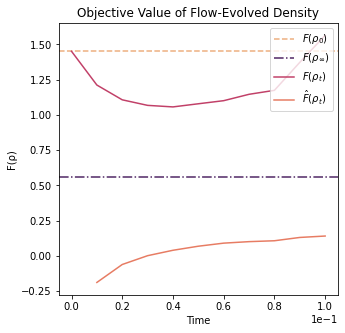

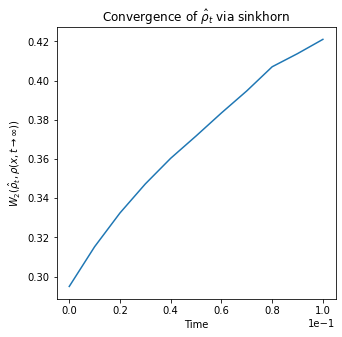

In [10]:
from src.functionals import FunctionalSum, PotentialFunctional, InternalEnergyFunctional


### Define functional: non-linear diffusion + potential 
f = lambda x: torch.pow(x, m)
multfun = lambda logr: torch.exp((m-1)*logr)
F1 = InternalEnergyFunctional(f, ρ0, X, multfun)

V = lambda x: torch.pow(x,2)
F2 = PotentialFunctional(V)

F  = FunctionalSum([F1, F2])


## Evaluation by integration of initial and steady state distributions
x, npoints = meshgrid_from(ρ=ρinf,  npoints_dim = 1001)
print(F.exact_eval(x,ρ=ρ0))
print(F.exact_eval(x,ρ=ρinf))


save_path = os.path.join(outdir, 'aggregation')
save_path = None

cb1 = PlottingCallback(animate=True, display_freq=1, same_fig=True,
                       show_density=True, ρinf = ρinf,  figsize=(5,5), 
                       density_method='kde',  use_sns=True, xrng=(-2,2), yrng=(0,2), 
                       show_trajectories=False, plot_pad=0.5, save_path=save_path)


cb2 = FunctionalValueCallback(F, ρ0=ρ0, ρinf=ρinf, integral_domain=(-2.0,2.0),
                              plot_F_obj=True, plot_F_estim=True)

cb3 = ConvergenceCallback(ρ_target=ρinf)

cb = CallbackList([cb1, cb2, cb3]) 


factory = lambda: FICNN(input_dim=1, hidden_dims=[200,50,20], nonlin='leaky_relu', dropout=0)


gf = GradFlow(X, F=F, ρ0=ρ0,
              τ=1e-2, lr=1e-3,
              convex_net = factory,
              strongify_icnn=None,              
              optimizer = 'adam',
              opt_iters=1000,
              callbacks=cb)

XT = gf.flow(steps=10)
plt.show()

In [11]:
HTML(cb1.animation.to_html5_video())

# 3. Aggregation Equation

### Instantiate initial and steady-state distributions

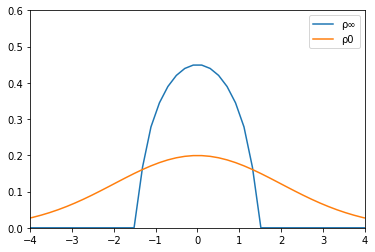

In [12]:
from src.pde import AggregationEquilibrium

ρinf = AggregationEquilibrium()

μ, σ = torch.tensor(0.0), torch.tensor(2.0)
ρ0 = torch.distributions.Normal(μ, σ)
X = ρ0.sample((1000,))
ρ0.domain = (-10.0,10.0)
ρinf.domain = (-4.0,4.0)


x = torch.linspace(*ρ0.domain,100)
fig, ax = plt.subplots()
ax.set_xlim(-4,4)
ax.set_ylim(0,0.6)
ax.plot(x, torch.exp(ρinf.log_prob(x)), label='ρ∞')
ax.plot(x, torch.exp(ρ0.log_prob(x)), label='ρ0')
ax.legend()
plt.show()

### JKO-ICNN Flow

Density BW: None
Exact query ranges: tensor(-10.0000) tensor(10.0000)


ζ = 1e-12
------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=𝒲(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------
   0   2.94e+00   5.87e+00     0.06     0.84   1.39e+00
 100   6.71e-01   8.22e-01     0.06     0.22   3.49e-03
 200   6.66e-01   7.97e-01     0.06     0.10   6.77e-04
 300   6.69e-01   7.91e-01     0.06     0.08   3.00e-04
 400   6.72e-01   7.87e-01     0.06     0.07   2.52e-04

---> After JKO Step: 1, F(ρ)=7.8659e-01 <---

Density BW: None
Exact query ranges: tensor(-10.0000) tensor(10.0000)
inversion error 0.08829784393310547
F(ρₜ)=  1.4313 (via exact computation)
ζ = 1e-12
------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=𝒲(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------
   0   1.95e-01   5.67e-01     0.07     0.08   3.45e-01
 100   1.15e-01   5.86e-01     0.07     0.07   1.08e-03
 200   1.14e-01   5.85e-01     0.07     0.07   1.08e-03
 300   1.16e

inversion error 0.012504339218139648
inversion error 0.0037431716918945312
inversion error 0.008523941040039062
inversion error 0.01425313949584961
inversion error 0.015553951263427734
inversion error 0.023424506187438965
inversion error 0.09794586896896362
inversion error 0.0558924674987793
inversion error 0.06891369819641113
F(ρₜ)=  1.0181 (via exact computation)


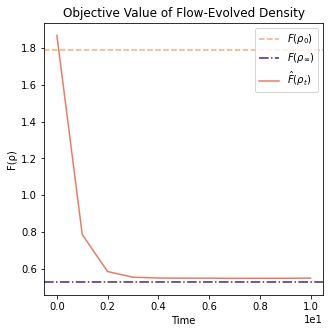

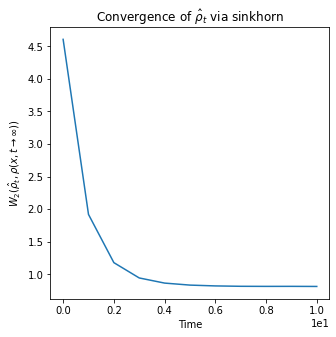

In [13]:
from src.functionals import InteractionFunctional

### Define Functional: Interaction Energy
W = lambda x: 0.5*torch.pow(x,2).sum(dim=-1) - torch.log(torch.norm(x,dim=-1))
F = InteractionFunctional(W)

#save_path = os.path.join(outdir, 'aggregation')
save_path = None

cb1 = PlottingCallback(animate=True, display_freq=1, same_fig=True,
                       show_density=True, ρ0=ρ0, ρinf = ρinf,  figsize=(4,4), 
                       density_method='kde',  use_sns=True, xrng=(-4,4), yrng=(0,0.6), 
                       show_trajectories=False, plot_pad=0.5, save_path=save_path)

cb2 = FunctionalValueCallback(F, ρ0=ρ0, ρinf=ρinf, integral_domain=(-10.0,10.0),
                              plot_F_obj=True, plot_F_estim=False)

cb3 = ConvergenceCallback(ρ_target=ρinf)

cb = CallbackList([cb1, cb2, cb3]) 

factory = lambda: FICNN(input_dim=1, hidden_dims=[50,50,50], nonlin='leaky_relu', dropout=0)


# Fast setting:  τ=1e0,  opt_iters=200
# Slow setting:  τ=1e-1, opt_iters=2000
gf = GradFlow(X, F=F, ρ0=ρ0,
              τ=1e0, lr=1e-3,
              convex_net = factory,
              strongify_icnn=1e-12,
              optimizer = 'adam',
              opt_iters=400,
              callbacks=cb)

XT = gf.flow(steps=10)
plt.show()

In [14]:
HTML(cb1.animation.to_html5_video())